## Análisis de la evolución de la remuneración profesional médica en Argentina. Período 2017-2023

A través de un ejercicio en lenguaje python, vamos a obtener la información de fuentes reales, en cuatro apartados diferentes: 
1. Pagos a profesionales de la medicina, proveniente de entidades intermediarias entre los mismos y los seguros de salud privados. 
2. Indice de inflacion publicado por el INDEC (Argentina)
3. Indice de precios al consumidor publicados por el INDEC (Argentina)
4. Valor del dolar en el mercado libre de restricciones. 

### Instalar librerias necesarias

In [1]:
# !pip install PyPDF2
# !pip install pdfplumber
# !pip install layoutparser torchvision 
# !pip install "git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
# !pip install "layoutparser[ocr]"
# !pip install pdf2image


In [4]:
import pandas as pd
from PyPDF2 import PdfReader, PdfWriter
import os
import re

PATH = "./data/processed/PDF PRESTACIONES 2017-2023/"

# Ruta de la carpeta con los archivos PDF de entrada
input_folder = PATH

# Carpeta de salida para guardar las páginas individuales
output_folder = PATH + "PDF POR PAGINAS"

#### **1. Extracción de datos de las liquidaciones de pago a profesionales.**

Las entidades intermediarias (conocidas como gerenciadoras) son instituciones que interceden entre el profesional autonomo y el seguro de salud privado. Se generan contratos colectivos que en teoría mejorar el poder de negociación de todos los profesionales adheridos, y a su vez brinda un servicio de gestión administrativa a los mismos concentrando y unificando flujos de documentación hacia y desde los financiadores (seguros).
El problema es que los reportes de pago que llegan al profesional dejan mucho que desear en cuanto a diseño y claridad en su lectura, estan llenos de tecnicismos contables y no son pasibles de extraer datos útiles on facilidad. 
En este trabajo vamos a intentar extraer de forma automatizada la información que consideramos útil para el análisis. 

Las gerenciadora pone a dispocision de los usuarios médicos una página web adonde estan alojados todos los reportes de pagos, en formato pdf. 

En [este notebook](Web_Scrapping_Rafaela_Obs.ipynb) vamos a codificar una extracción automática de los mismos, haciendo un loggin, y recorriendo los diferentes botones de la web hasta el de descarga, con un bucle for se automatiza la descarga de todos los archivos. 

Una vez que tenemos todos los pdfs descargados en nuestra carpeta data/raw/PDF PRESTACIONES 2017-2023, comenzamos con el proceso de extracción. 

Lo que queremos obtener es el valor pagado por una cesárea y la fecha de realización del procedimiento. 


El primer problema es que los pdf estan rotados 90 grados. 

In [3]:
# # Los archivos pdf estan rotados. Vamos a ponerlos en horizontal.

# def rotate_pdf(input_path, output_path, rotation_angle):
#     with open(input_path, "rb") as file:
#         pdf = PdfReader(file)
#         output_pdf = PdfWriter()

#         for page_num in range(len(pdf.pages)):
#             page = pdf.pages[page_num]
#             page.rotate(rotation_angle)
#             output_pdf.add_page(page)

#         with open(output_path, "wb") as output_file:
#             output_pdf.write(output_file)

# # Ruta de la carpeta con los archivos PDF
# folder_path = "./Comparativa Honorarios Medicos Argentina/data/PDF PRESTACIONES 2017-2023"

# # Ángulo de rotación en sentido horario (90 grados en este caso)
# rotation_angle = 90

# # Obtener la lista de archivos en la carpeta
# file_list = os.listdir(folder_path)

# # Procesar cada archivo PDF en la carpeta
# for file_name in file_list:
#     if file_name.endswith(".pdf"):
#         input_file = os.path.join(folder_path, file_name)
#         output_file = os.path.join(folder_path, "rotated_" + file_name)
#         rotate_pdf(input_file, output_file, rotation_angle)
#         print(f"Archivo {file_name} rotado y guardado como {output_file}")


In [4]:
# reader = PdfReader("./data/PDF PRESTACIONES 2017-2023/rotated_sabanaPorMandato420Prestacionesagosto2020.pdf")
# page = reader.pages[0]
# texto_pdf = page.extract_text()
# print(type(texto_pdf))
# len(reader.pages)

In [5]:
# print(texto_pdf.find('cesarea'))
# print(len(texto_pdf))

In [6]:
# print(texto_pdf)

In [7]:
# posicion = 1295
# texto_recortado = texto_pdf[posicion:]

# print(texto_recortado)

In [8]:
PATH = "./data/processed/PDF PRESTACIONES 2017-2023/"

Otro problema es que las liquidaciones pueden tener varias paginas, en cuyo caso la extraccion de texto por posición quedaria restringido solo a la primera pagina. En este caso lo resolvemos separando por páginas y creando documentos nuevos de una sola página. 

In [9]:
# # Una función que guarda cada pagina como un pdf separado

# def split_pdf_pages(input_folder, output_folder, file_name):
#     with open(input_folder  , "rb") as file:
#         pdf = PdfReader(file)

#         # Recorrer cada página del PDF
#         for page_num in range(len(pdf.pages)):
#             # Aca se crea un archivo pdf nuevo, vacío, y se agrega en cada iteracion una pagina diferente del archivo            
#             output_pdf = PdfWriter()
#             output_pdf.add_page(page=pdf.pages[page_num])

#             # Generar el nombre del archivo de salida
#             output_file = f"{output_folder}/{file_name}_page_{page_num+1}.pdf"

#             with open(output_file, "wb") as output:
#                 output_pdf.write(output)
#             # print(f"Página {page_num+1} guardada como {output_file}")

# # Ruta de la carpeta con los archivos PDF de entrada
# input_folder = PATH

# # Carpeta de salida para guardar las páginas individuales
# output_folder = PATH + "PDF POR PAGINAS"

# # Obtener la lista de archivos en la carpeta de entrada
# file_list = os.listdir(input_folder)

# # Procesar cada archivo PDF en la carpeta
       
# for file_name in file_list:
#     if file_name.endswith(".pdf"):
#         ruta_archivo = os.path.join(PATH, file_name)
#         split_pdf_pages(ruta_archivo, output_folder, file_name)
#         # print(f"Archivo {file_name} dividido en páginas")


Una vez que tenemos los pdfs preparados, vamos a comenzar con la extracción de la informacion que nos interesa.

In [5]:
# En este bloque de codigo, vamos a extraer texto de cada archivo, y con expresiones regulares 
# seleccionamos las fechas, practicas y valores para guardarlos en un dataframe

fechas = []
practicas = []
valores = []

for nombre_archivo in os.listdir(output_folder):
    if nombre_archivo.endswith(".pdf"):
        ruta_archivo = os.path.join(output_folder, nombre_archivo)
    
    
        with open(ruta_archivo, "rb") as archivo:
            pdf = PdfReader(archivo)
            texto = pdf.pages[0].extract_text()

        texto_recortado = texto[1295:]

        cesarea_match = re.search(r"cesarea", texto_recortado)
        if cesarea_match:
            practica = cesarea_match.group()
            practicas.append(practica)
        
        if 'cesarea' in texto_recortado:
            fecha_match = re.search(r"\d{2}/\d{2}/\d{4}", texto_recortado)
            if fecha_match:
                fecha = fecha_match.group()
                fechas.append(fecha)

        numero_match = re.search(r"cesarea.*?(\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{2}))", texto_recortado)
        if numero_match:
            valor = numero_match.group(1)
            valores.append(valor)

print('Fechas:', len(fechas))
print('Cesareas:', len(practicas))
print('Valor:', len(valores))

data = {
    "Fecha": fechas,
    "Practica": practicas,
    "Valor": valores
}
df = pd.DataFrame(data)

    

Fechas: 46
Cesareas: 46
Valor: 46


In [11]:
# Guardamos el archivo con los datos extraidos
ruta_salida = os.path.join(PATH, "datos_extraidos.csv")
df.to_csv(ruta_salida, index=False)

In [12]:
df['Valor'].value_counts()

933,67       5
1.212,39     2
5,061.39     2
11.539,22    2
1.171,80     2
1.042,48     2
6.412,09     1
40.747,73    1
3.922,74     1
962,13       1
3,676.77     1
2.027,21     1
7.747,94     1
1.381,05     1
12.815,70    1
10.941,26    1
2.420,19     1
13.241,90    1
2.368,71     1
5.004,14     1
2.881,37     1
725,68       1
725.68       1
7.353,55     1
4.401,95     1
2.156,95     1
998,96       1
808,54       1
1.759,09     1
23.462,23    1
2.521,46     1
9.145,29     1
9.217,38     1
933.67       1
10.271,22    1
1.132,46     1
1.365,61     1
Name: Valor, dtype: int64

Verificamos la información básica, y los datos estan en formato string. 
Hermos las trasnformaciones pertinentes.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Fecha     46 non-null     object
 1   Practica  46 non-null     object
 2   Valor     46 non-null     object
dtypes: object(3)
memory usage: 1.2+ KB


In [7]:
# Transformamos la columna Valor a float
df['Valor'] = df['Valor'].str.replace(r'\.(\d{2}\b)', r',\1')
df['Valor'] = df['Valor'].str.replace(r'[.,](?=\d{3}\b)', '')
df['Valor'] = df['Valor'].str.replace(',', '.')
df['Valor'] = df['Valor'].astype(float)

C:\Users\Rafael Ortega\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\Rafael Ortega\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
from datetime import datetime

# Convertimos la columna Fecha a datetime

df['Fecha'] = pd.to_datetime(df['Fecha'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Fecha     46 non-null     datetime64[ns]
 1   Practica  46 non-null     object        
 2   Valor     46 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.2+ KB


In [10]:
df.sort_values('Fecha', inplace=True)
df = df.reset_index(drop=True)
df.head(50)

,Fecha,Practica,Valor
0,2017-01-05,cesarea,725.68
1,2017-01-09,cesarea,1365.61
2,2017-01-10,cesarea,5004.14
3,2017-03-05,cesarea,962.13
4,2017-04-25,cesarea,3922.74
5,2017-06-10,cesarea,933.67
6,2017-06-30,cesarea,808.54
7,2017-07-11,cesarea,933.67
8,2017-09-06,cesarea,4401.95
9,2017-11-22,cesarea,933.67


Cuando vemos el detalle de los valores, nos llaman la atencion que hay algunos mucho mas bajos que otros. La explicacion es que los reportes no diferencian entre el rol de cirujano y el de ayudante quirurgico, y el valor que corresponde a este ultimo es del 20% del valor del cirujano. Entonces tendremos que quitar estas filas que corresponden a ayudantias. 

Para resolver este problema creamos una columna auxiliar que muestra un volar igual al valor siguiente dividido 3.5.  Si el valor actual es menor que el valor de "filtro", es altamente probable que se deba a una ayudantía. 

(*) El intervalo maximo de meses entre observaciones es de 3. Nunca va a ocurrir una actualizacion de valores de 3,5 veces en es periodo. 

In [11]:
df1 = df

In [12]:
df1['filtrar'] = df1['Valor'].shift(-1) / 3.5

In [13]:
df1.head(50)

,Fecha,Practica,Valor,filtrar
0,2017-01-05,cesarea,725.68,390.174286
1,2017-01-09,cesarea,1365.61,1429.754286
2,2017-01-10,cesarea,5004.14,274.894286
3,2017-03-05,cesarea,962.13,1120.782857
4,2017-04-25,cesarea,3922.74,266.762857
5,2017-06-10,cesarea,933.67,231.011429
6,2017-06-30,cesarea,808.54,266.762857
7,2017-07-11,cesarea,933.67,1257.700000
8,2017-09-06,cesarea,4401.95,266.762857
9,2017-11-22,cesarea,933.67,266.762857


In [14]:
df1_high_values = df1.iloc[-2:]
df1_high_values

,Fecha,Practica,Valor,filtrar
44,2022-05-01,cesarea,23462.23,11642.208571
45,2023-04-03,cesarea,40747.73,NaN


Este bucle while consigue que ningun valor de la columna 'valor' sea menor que el correspondiente de la columna 'filtrar'. 
En otras palabras, todos los valores que sean menores que el valor previo / 3.5, seran interpretados como ayudantias y serán eliminados.

In [15]:
while any(df1['Valor'][:-1] < df1['filtrar'][:-1]):
    # Filtrar los valores que son menores que el valor correspondiente en 'Filtrar'
    df1 = df1[df1['Valor'] >= df1['filtrar']]
    # Actualizar la columna 'Filtrar' con los nuevos valores después del filtro
    df1['filtrar'] = df1['Valor'].shift(-1) / 3.5


C:\Users\Rafael Ortega\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [16]:
df1.head(50)

,Fecha,Practica,Valor,filtrar
2,2017-01-10,cesarea,5004.14,1120.782857
4,2017-04-25,cesarea,3922.74,1257.700000
8,2017-09-06,cesarea,4401.95,1446.111429
13,2018-02-20,cesarea,5061.39,1446.111429
15,2018-04-17,cesarea,5061.39,1050.505714
16,2018-04-23,cesarea,3676.77,2213.697143
20,2018-10-10,cesarea,7747.94,2101.014286
25,2019-05-04,cesarea,7353.55,2612.940000
27,2019-09-11,cesarea,9145.29,2633.537143
28,2019-09-12,cesarea,9217.38,3661.628571


A continuación agregamos los dos ultimos registros que habíamos guardado por separado, y luego eliminamos la columna auxiliar 'flitrar'

In [17]:
df2 = pd.concat([df1, df1_high_values])

In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 2 to 45
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Fecha     18 non-null     datetime64[ns]
 1   Practica  18 non-null     object        
 2   Valor     18 non-null     float64       
 3   filtrar   16 non-null     float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 720.0+ bytes


In [19]:
df2.head(20)

,Fecha,Practica,Valor,filtrar
2,2017-01-10,cesarea,5004.14,1120.782857
4,2017-04-25,cesarea,3922.74,1257.700000
8,2017-09-06,cesarea,4401.95,1446.111429
13,2018-02-20,cesarea,5061.39,1446.111429
15,2018-04-17,cesarea,5061.39,1050.505714
16,2018-04-23,cesarea,3676.77,2213.697143
20,2018-10-10,cesarea,7747.94,2101.014286
25,2019-05-04,cesarea,7353.55,2612.940000
27,2019-09-11,cesarea,9145.29,2633.537143
28,2019-09-12,cesarea,9217.38,3661.628571


In [20]:
df3 = df2.drop('filtrar', axis=1)

Otra situacion con la cual nos encontramos, es que cada financiador tiene un valor diferente, quenos obligaria a hacer una linea de tiempo para cada uno de ellos. Como no tenemos datos suficientes de cada financiador, y ademas multiplicaria el tiempo de analisis, no tenemos mas alternativa que quedarnos solo con los registros que muestran un aumento con respcto al valor anterior. 
No nos importa tener una alto realismo de los datos (exacto el valor de tal o cual financiador) porque lo que queremos obtener es una tendencia general del valor de la práctica. 

In [21]:
df3['Valor_Corregido'] = df3['Valor']

# Recorrer el DataFrame y eliminar los valores menores que el valor previo
for i in range(1, len(df3)):
    if df3.iloc[i,3] < df3.iloc[i-1,3]:
        df3.iloc[i,3] = -9999

# Eliminar las filas con valores NA en la columna 'Valor_Corregido'
df4 = df3[df3['Valor_Corregido'] != -9999]
df5 = df4.drop_duplicates(subset=['Valor'])

for i in range(1, len(df5)):
    if df5.iloc[i,3] < df5.iloc[i-1,3]:
        df5.iloc[i,3] = -9999

df6 = df5[df5['Valor_Corregido'] != -9999].drop('Valor_Corregido', axis=1)

df6.head(20)

c:\Users\Rafael Ortega\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Fecha,Practica,Valor
2,2017-01-10,cesarea,5004.14
13,2018-02-20,cesarea,5061.39
20,2018-10-10,cesarea,7747.94
27,2019-09-11,cesarea,9145.29
28,2019-09-12,cesarea,9217.38
29,2019-10-21,cesarea,12815.70
35,2020-09-09,cesarea,13241.90
44,2022-05-01,cesarea,23462.23
45,2023-04-03,cesarea,40747.73


In [29]:
df7 = df6.set_index('Fecha', drop=True)
df7.head(15)


,Practica,Valor
Fecha,,
2017-01-10,cesarea,5004.14
2018-02-20,cesarea,5061.39
2018-10-10,cesarea,7747.94
2019-09-11,cesarea,9145.29
2019-09-12,cesarea,9217.38
2019-10-21,cesarea,12815.70
2020-09-09,cesarea,13241.90
2022-05-01,cesarea,23462.23
2023-04-03,cesarea,40747.73


In [30]:
df7['Mes'] = df7.index.month
df7['Año'] = df7.index.year
df7['mes_año'] = df7.index.to_period('M')

In [31]:
df7.head(20)

,Practica,Valor,Mes,Año,mes_año
Fecha,,,,,
2017-01-10,cesarea,5004.14,1,2017,2017-01
2018-02-20,cesarea,5061.39,2,2018,2018-02
2018-10-10,cesarea,7747.94,10,2018,2018-10
2019-09-11,cesarea,9145.29,9,2019,2019-09
2019-09-12,cesarea,9217.38,9,2019,2019-09
2019-10-21,cesarea,12815.70,10,2019,2019-10
2020-09-09,cesarea,13241.90,9,2020,2020-09
2022-05-01,cesarea,23462.23,5,2022,2022-05
2023-04-03,cesarea,40747.73,4,2023,2023-04


In [32]:
df_group = df7.groupby('mes_año').max()
df_group

,Practica,Valor,Mes,Año
mes_año,,,,
2017-01,cesarea,5004.14,1,2017
2018-02,cesarea,5061.39,2,2018
2018-10,cesarea,7747.94,10,2018
2019-09,cesarea,9217.38,9,2019
2019-10,cesarea,12815.70,10,2019
2020-09,cesarea,13241.90,9,2020
2022-05,cesarea,23462.23,5,2022
2023-04,cesarea,40747.73,4,2023


In [33]:
type(df_group.index)

pandas.core.indexes.period.PeriodIndex

In [34]:
# Guardamos el dataframe de fecha, cesarea y valor
ruta_salida = os.path.join(PATH, "cesareas_valor_2017-2023.csv")
df_group.to_csv(ruta_salida, index=True)

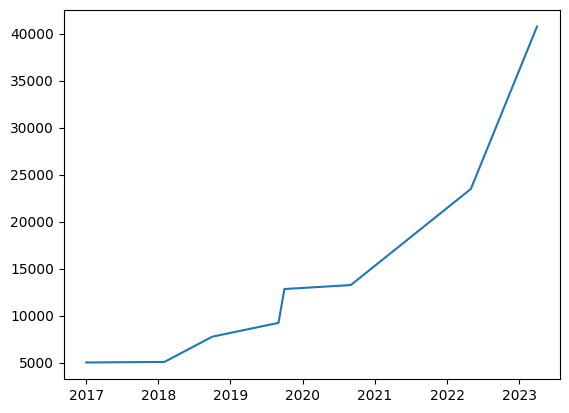

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

df_group.index = df_group.index.to_timestamp()

plt.plot(df_group.index, df_group['Valor'])


**----------------------------------------------------------------------------------------------------------------------------------------**

### **Datos de valores históricos de dólar informal**

In [36]:
# Fuente: http://estudiodelamo.com/cotizacion-historica-dolar-peso-argentina/

dolar_blue = pd.read_csv('./data/raw/Inflacion vs Dolar Blue - Dolar informal.csv')


In [37]:
dolar_blue.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,NaN,Variación anual dólar informal\n (según último...,ENE,FEB,MAR,ABR,MAY,JUN,JUL,AGO,SEP,OCT,NOV,DIC
1,2011.0,"15,28%","$4,13","$4,15","$4,15","$4,30","$4,29","$4,27","$4,34","$4,43","$4,43","$4,48","$4,62","$4,73"
2,2012.0,"43,34%","$4,78","$4,71","$4,92","$5,07","$5,90","$5,93","$6,29","$6,35","$6,28","$6,32","$6,42","$6,78"
3,2013.0,"46,76%","$7,89","$7,82","$8,38","$9,37","$8,75","$8,00","$8,48","$9,20","$9,43","$9,87","$9,53","$9,95"
4,2014.0,"37,69%","$11,15","$11,20","$10,70","$10,45","$11,30","$12,05","$12,60","$13,95","$15,60","$14,18","$13,00","$13,70"


In [38]:
# Cambio el nombre de la columna que tiene los años

dolar_blue['Unnamed: 0'].fillna('Año', inplace=True)

In [39]:
 # Ponemos los valores de la primera fila como nombres de columnas
dolar_blue.columns = dolar_blue.iloc[0]                

# Eliminamos la primera fila, que queda duplicada con los nombres nuevos de las columnas
dolar_blue = dolar_blue[1:]            

# Eliminamos la primera fila, que queda duplicada con los nombres nuevos de las columnas
dolar_blue.drop(columns=['Variación anual dólar informal\n (según último \n mes del año)'], inplace=True)

dolar_blue.head()

,Año,ENE,FEB,MAR,ABR,MAY,JUN,JUL,AGO,SEP,OCT,NOV,DIC
1,2011.0,"$4,13","$4,15","$4,15","$4,30","$4,29","$4,27","$4,34","$4,43","$4,43","$4,48","$4,62","$4,73"
2,2012.0,"$4,78","$4,71","$4,92","$5,07","$5,90","$5,93","$6,29","$6,35","$6,28","$6,32","$6,42","$6,78"
3,2013.0,"$7,89","$7,82","$8,38","$9,37","$8,75","$8,00","$8,48","$9,20","$9,43","$9,87","$9,53","$9,95"
4,2014.0,"$11,15","$11,20","$10,70","$10,45","$11,30","$12,05","$12,60","$13,95","$15,60","$14,18","$13,00","$13,70"
5,2015.0,"$13,50","$12,93","$12,52","$12,60","$12,55","$13,30","$14,79","$15,32","$15,84","$15,60","$14,59","$14,17"


In [40]:
# Cambiamos el tipo de dato de la columna Año

dolar_blue['Año'] = dolar_blue['Año'].astype(int)

In [41]:
# Pivoteo los meses como un MultiIndex vertical

dolar_blue_1 = dolar_blue.melt(id_vars='Año', var_name='Mes', value_name='Valor')

In [42]:
dolar_blue_1.sort_values(by=['Año']).head(50)

,Año,Mes,Valor
0,2011,ENE,"$4,13"
130,2011,NOV,"$4,62"
117,2011,OCT,"$4,48"
104,2011,SEP,"$4,43"
91,2011,AGO,"$4,43"
78,2011,JUL,"$4,34"
65,2011,JUN,"$4,27"
52,2011,MAY,"$4,29"
39,2011,ABR,"$4,30"
26,2011,MAR,"$4,15"


In [43]:
filtro = dolar_blue_1['Año'] > 2016
mapping_mes = { 'ENE':1, 'FEB':2, 'MAR':3, 'ABR':4, 'MAY':5, 'JUN':6, 'JUL':7, 'AGO':8, 'SEP':9, 'OCT':10, 'NOV':11, 'DIC':12 }


In [44]:
# Las trasnformaciones son: Slice años desde 2017, codificar meses con sus numeros

dolar_blue_2 = dolar_blue_1[filtro].copy()

In [45]:
dolar_blue_2['Mes'] = dolar_blue_2['Mes'].map(mapping_mes)

In [46]:
dolar_blue_2.sort_values(by=['Año', 'Mes']).head(20)

,Año,Mes,Valor
6,2017,1,"$16,24"
19,2017,2,"$15,88"
32,2017,3,"$15,58"
45,2017,4,"$15,59"
58,2017,5,"$15,99"
71,2017,6,"$16,44"
84,2017,7,"$17,65"
97,2017,8,"$17,83"
110,2017,9,"$17,51"
123,2017,10,"$17,70"


In [47]:
# Creamos una columna 'mes_año' tomando los valroes correspondientes

dolar_blue_2['mes_año'] = pd.to_datetime(dolar_blue_2['Año'].astype(str) + '-' + dolar_blue_2['Mes'].astype(str))
dolar_blue_2['mes_año'] = dolar_blue_2['mes_año'].dt.strftime('%Y-%m')

In [48]:
# Ponemos la nueva columna como index

dolar_blue_2.set_index('mes_año', inplace=True)

In [49]:
# La columna valor debe ser un float
dolar_blue_2['Valor'] = dolar_blue_2['Valor'].str.replace('$', '')
dolar_blue_2['Valor'] = dolar_blue_2['Valor'].str.replace(',', '.')
dolar_blue_2['Valor'] = dolar_blue_2['Valor'].astype(float)


C:\Users\Rafael Ortega\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [50]:
dolar_blue_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84 entries, 2017-01 to 2023-12
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Año     84 non-null     int32  
 1   Mes     84 non-null     int64  
 2   Valor   77 non-null     float64
dtypes: float64(1), int32(1), int64(1)
memory usage: 2.3+ KB


In [51]:
# Eliminamos los null de 'Valor'

dolar_blue_3 = dolar_blue_2.dropna(subset=['Valor'])

In [52]:
dolar_blue_3 = dolar_blue_3.sort_index(ascending=True)

In [53]:
dolar_blue_3['Incremento %'] = (((dolar_blue_3['Valor'] - dolar_blue_3['Valor'].shift(1)) / dolar_blue_3['Valor'].shift(1)) * 100).round(2)

In [54]:
dolar_blue_3

,Año,Mes,Valor,Incremento %
mes_año,,,,
2017-01,2017,1,16.24,NaN
2017-02,2017,2,15.88,-2.22
2017-03,2017,3,15.58,-1.89
2017-04,2017,4,15.59,0.06
2017-05,2017,5,15.99,2.57
...,...,...,...,...
2023-01,2023,1,379.00,10.82
2023-02,2023,2,373.00,-1.58
2023-03,2023,3,388.00,4.02


In [55]:
dolar_blue_3.to_csv('./data/processed/Dolar informal_procesado.csv')

In [56]:
type(dolar_blue_3.index)

pandas.core.indexes.base.Index

In [57]:
type(df_group.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [58]:
type(df_group.index) == type(dolar_blue_3.index)

False

In [59]:
dolar_blue_3.index = pd.to_datetime(dolar_blue_3.index)

In [60]:
# dolar_blue_3.index = dolar_blue_3.index.to_timestamp()

In [61]:
type(dolar_blue_3.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [62]:
df_completo = pd.merge(df_group, dolar_blue_3, left_index=True, right_index=True, how='inner')

df_completo

,Practica,Valor_x,Mes_x,Año_x,Año_y,Mes_y,Valor_y,Incremento %
mes_año,,,,,,,,
2017-01-01,cesarea,5004.14,1,2017,2017,1,16.24,NaN
2018-02-01,cesarea,5061.39,2,2018,2018,2,19.95,2.05
2018-10-01,cesarea,7747.94,10,2018,2018,10,34.50,-12.21
2019-09-01,cesarea,9217.38,9,2019,2019,9,58.25,-2.92
2019-10-01,cesarea,12815.70,10,2019,2019,10,66.00,13.30
2020-09-01,cesarea,13241.90,9,2020,2020,9,140.00,6.87
2022-05-01,cesarea,23462.23,5,2022,2022,5,201.00,2.29
2023-04-01,cesarea,40747.73,4,2023,2023,4,462.00,19.07


In [63]:
df_completo.rename(columns={'Valor_x': 'Valor_cesarea', 'Valor_y':'Valor_dolar_blue'}, inplace=True)

In [64]:
df_completo.drop(columns=['Año_x', 'Año_y', 'Mes_x', 'Mes_y','Practica'], inplace=True)

In [65]:
df_completo.head(10)

,Valor_cesarea,Valor_dolar_blue,Incremento %
mes_año,,,
2017-01-01,5004.14,16.24,NaN
2018-02-01,5061.39,19.95,2.05
2018-10-01,7747.94,34.50,-12.21
2019-09-01,9217.38,58.25,-2.92
2019-10-01,12815.70,66.00,13.30
2020-09-01,13241.90,140.00,6.87
2022-05-01,23462.23,201.00,2.29
2023-04-01,40747.73,462.00,19.07


**------------------------------------------------------------------------------------------------------------------------------**-

## **Datos de inflación**

In [66]:
# Fuente: http://estudiodelamo.com/cotizacion-historica-inflacion-argentina/

infla = pd.read_csv('./data/raw/Inflacion vs Dolar Blue - Inflacion en %.csv')

In [67]:
infla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   14 non-null     object
 1   Unnamed: 1   14 non-null     object
 2   Unnamed: 2   14 non-null     object
 3   Unnamed: 3   14 non-null     object
 4   Unnamed: 4   14 non-null     object
 5   Unnamed: 5   14 non-null     object
 6   Unnamed: 6   13 non-null     object
 7   Unnamed: 7   13 non-null     object
 8   Unnamed: 8   13 non-null     object
 9   Unnamed: 9   13 non-null     object
 10  Unnamed: 10  13 non-null     object
 11  Unnamed: 11  13 non-null     object
 12  Unnamed: 12  13 non-null     object
 13  Unnamed: 13  13 non-null     object
dtypes: object(14)
memory usage: 1.7+ KB


In [68]:
infla.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,AÑO,Inflación Anual,ENE,FEB,MAR,ABR,MAY,JUN,JUL,AGO,SEP,OCT,NOV,DIC
1,2011,"12,67%","1,09%","0,93%","0,96%","1,00%","1,03%","1,14%","1,01%","1,02%","1,03%","0,91%","0,95%","0,92%"
2,2012,"13,13%","0,96%","0,99%","1,18%","1,13%","1,02%","0,99%","0,97%","1,03%","1,11%","1,03%","1,00%","0,97%"
3,2013,"14,76%","1,02%","1,06%","1,01%","0,96%","1,26%","1,35%","1,13%","1,13%","1,09%","1,14%","1,22%","1,49%"
4,2014,"28,27%","4,95%","5,12%","2,43%","1,72%","1,87%","1,51%","1,35%","1,63%","1,59%","1,23%","0,91%","0,95%"


In [69]:
 # Ponemos los valores de la primera fila como nombres de columnas
infla.columns = infla.iloc[0]                

# Eliminamos la primera fila, que queda duplicada con los nombres nuevos de las columnas
infla = infla[1:]            

# Eliminamos la primera fila, que queda duplicada con los nombres nuevos de las columnas
infla.drop(columns=['Inflación Anual'], inplace=True)

infla.head()

,AÑO,ENE,FEB,MAR,ABR,MAY,JUN,JUL,AGO,SEP,OCT,NOV,DIC
1,2011,"1,09%","0,93%","0,96%","1,00%","1,03%","1,14%","1,01%","1,02%","1,03%","0,91%","0,95%","0,92%"
2,2012,"0,96%","0,99%","1,18%","1,13%","1,02%","0,99%","0,97%","1,03%","1,11%","1,03%","1,00%","0,97%"
3,2013,"1,02%","1,06%","1,01%","0,96%","1,26%","1,35%","1,13%","1,13%","1,09%","1,14%","1,22%","1,49%"
4,2014,"4,95%","5,12%","2,43%","1,72%","1,87%","1,51%","1,35%","1,63%","1,59%","1,23%","0,91%","0,95%"
5,2015,"0,20%","0,25%","0,98%","0,74%","1,48%","1,32%","1,44%","1,33%","1,35%","0,93%","2,00%","3,90%"


In [70]:
# Cambiamos el tipo de dato de la columna Año

infla['AÑO'] = infla['AÑO'].astype(int)

In [71]:
# Cambio el nombre de la columna que tiene los años

infla = infla.rename(columns={'AÑO':'Año'}) 

In [72]:
# Pivoteo los meses como un MultiIndex vertical

infla_1 = infla.melt(id_vars='Año', var_name='Mes', value_name='Valor')

In [73]:
infla_1.sort_values(by=['Año']).head(50)

,Año,Mes,Valor
0,2011,ENE,"1,09%"
130,2011,NOV,"0,95%"
117,2011,OCT,"0,91%"
104,2011,SEP,"1,03%"
91,2011,AGO,"1,02%"
78,2011,JUL,"1,01%"
65,2011,JUN,"1,14%"
52,2011,MAY,"1,03%"
39,2011,ABR,"1,00%"
26,2011,MAR,"0,96%"


In [74]:
filtro = infla_1['Año'] > 2016
mapping_mes = { 'ENE':1, 'FEB':2, 'MAR':3, 'ABR':4, 'MAY':5, 'JUN':6, 'JUL':7, 'AGO':8, 'SEP':9, 'OCT':10, 'NOV':11, 'DIC':12 }


In [75]:
# Las trasnformaciones son: Slice años desde 2017, codificar meses con sus numeros

infla_2 = infla_1[filtro].copy()

In [76]:
infla_2['Mes'] = infla_2['Mes'].map(mapping_mes)

In [77]:
infla_2.sort_values(by=['Año', 'Mes']).head(20)

,Año,Mes,Valor
6,2017,1,"1,59%"
19,2017,2,"2,07%"
32,2017,3,"2,37%"
45,2017,4,"2,66%"
58,2017,5,"1,43%"
71,2017,6,"1,19%"
84,2017,7,"1,73%"
97,2017,8,"1,40%"
110,2017,9,"1,90%"
123,2017,10,"1,51%"


In [78]:
# Creamos una columna 'mes_año' tomando los valores correspondientes

infla_2['mes_año'] = pd.to_datetime(infla_2['Año'].astype(str) + '-' + infla_2['Mes'].astype(str))
infla_2['mes_año'] = infla_2['mes_año'].dt.strftime('%Y-%m')

In [79]:
# Ponemos la nueva columna como index

infla_2.set_index('mes_año', inplace=True)

In [80]:
# La columna valor debe ser un float
infla_2['Valor'] = infla_2['Valor'].str.replace('%', '')
infla_2['Valor'] = infla_2['Valor'].str.replace(',', '.')
infla_2['Valor'] = infla_2['Valor'].astype(float)


In [81]:
infla_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84 entries, 2017-01 to 2023-12
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Año     84 non-null     int32  
 1   Mes     84 non-null     int64  
 2   Valor   76 non-null     float64
dtypes: float64(1), int32(1), int64(1)
memory usage: 2.3+ KB


In [82]:
# Eliminamos los null de 'Valor'

infla_3 = infla_2.dropna(subset=['Valor'])

In [83]:
# Ordenamos el indice ascendente

infla_3 = infla_3.sort_index(ascending=True)

In [84]:
infla_3

,Año,Mes,Valor
mes_año,,,
2017-01,2017,1,1.59
2017-02,2017,2,2.07
2017-03,2017,3,2.37
2017-04,2017,4,2.66
2017-05,2017,5,1.43
...,...,...,...
2022-12,2022,12,5.12
2023-01,2023,1,6.03
2023-02,2023,2,6.63


In [85]:
infla_3['Valor'] = (infla_3['Valor'] / 100).round(2)

In [86]:
infla_3['Inflacion acumulada %'] = infla_3['Valor'].cumsum()

In [87]:
infla_3['Inflacion acumulada % prod'] = (1 + infla_3['Valor']).cumprod() - 1

In [88]:
infla_3['Inflacion acumulada %'].mean()

1.1490789473684213

In [89]:
infla_3['Inflacion acumulada % prod'] = infla_3['Inflacion acumulada % prod']*100

In [90]:
infla_3.head(40)

,Año,Mes,Valor,Inflacion acumulada %,Inflacion acumulada % prod
mes_año,,,,,
2017-01,2017,1,0.02,0.02,2.000000
2017-02,2017,2,0.02,0.04,4.040000
2017-03,2017,3,0.02,0.06,6.120800
2017-04,2017,4,0.03,0.09,9.304424
2017-05,2017,5,0.01,0.10,10.397468
2017-06,2017,6,0.01,0.11,11.501443
2017-07,2017,7,0.02,0.13,13.731472
2017-08,2017,8,0.01,0.14,14.868786
2017-09,2017,9,0.02,0.16,17.166162


In [91]:
infla_3.to_csv('./data/processed/Inflacion_procesado.csv')

In [92]:
print(type(df_completo.index))
print(type(infla_3.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.indexes.base.Index'>


In [93]:
infla_3.index = pd.to_datetime(infla_3.index)

In [94]:
print(type(infla_3.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [95]:
print(type(df_completo.index))
print(type(infla_3.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [96]:
infla_3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 76 entries, 2017-01-01 to 2023-04-01
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Año                         76 non-null     int32  
 1   Mes                         76 non-null     int64  
 2   Valor                       76 non-null     float64
 3   Inflacion acumulada %       76 non-null     float64
 4   Inflacion acumulada % prod  76 non-null     float64
dtypes: float64(3), int32(1), int64(1)
memory usage: 3.3 KB


In [97]:
type(infla_3.index) == type(df_completo.index)

True

In [98]:
infla_3.index.name == df_completo.index.name

True

In [99]:
len(infla_3.index) == len(df_completo.index)

False

In [100]:
# Unir con df_completo

df_completo_2 = pd.merge(df_completo, infla_3, left_index=True, right_index=True, how='inner')

df_completo_2

,Valor_cesarea,Valor_dolar_blue,Incremento %,Año,Mes,Valor,Inflacion acumulada %,Inflacion acumulada % prod
mes_año,,,,,,,,
2017-01-01,5004.14,16.24,NaN,2017,1,0.02,0.02,2.000000
2018-02-01,5061.39,19.95,2.05,2018,2,0.02,0.26,29.348477
2018-10-01,7747.94,34.50,-12.21,2018,10,0.05,0.56,73.490567
2019-09-01,9217.38,58.25,-2.92,2019,9,0.06,0.95,154.367271
2019-10-01,12815.70,66.00,13.30,2019,10,0.03,0.98,161.998289
2020-09-01,13241.90,140.00,6.87,2020,9,0.03,1.27,248.720788
2022-05-01,23462.23,201.00,2.29,2022,5,0.05,2.08,670.587087
2023-04-01,40747.73,462.00,19.07,2023,4,0.08,2.78,1418.119868


In [101]:
df_completo_3 = df_completo_2.drop(columns=['Año', 'Mes'])
df_completo_4 = df_completo_3.rename(columns={'Valor':'Inflacion %'})

In [102]:
df_completo_4.head()

,Valor_cesarea,Valor_dolar_blue,Incremento %,Inflacion %,Inflacion acumulada %,Inflacion acumulada % prod
mes_año,,,,,,
2017-01-01,5004.14,16.24,NaN,0.02,0.02,2.000000
2018-02-01,5061.39,19.95,2.05,0.02,0.26,29.348477
2018-10-01,7747.94,34.50,-12.21,0.05,0.56,73.490567
2019-09-01,9217.38,58.25,-2.92,0.06,0.95,154.367271
2019-10-01,12815.70,66.00,13.30,0.03,0.98,161.998289


In [103]:
df_completo_4['Inflacion acumulada %'] = df_completo_4['Inflacion %'].cumsum()

In [104]:
df_completo_4.head(20)

,Valor_cesarea,Valor_dolar_blue,Incremento %,Inflacion %,Inflacion acumulada %,Inflacion acumulada % prod
mes_año,,,,,,
2017-01-01,5004.14,16.24,NaN,0.02,0.02,2.000000
2018-02-01,5061.39,19.95,2.05,0.02,0.04,29.348477
2018-10-01,7747.94,34.50,-12.21,0.05,0.09,73.490567
2019-09-01,9217.38,58.25,-2.92,0.06,0.15,154.367271
2019-10-01,12815.70,66.00,13.30,0.03,0.18,161.998289
2020-09-01,13241.90,140.00,6.87,0.03,0.21,248.720788
2022-05-01,23462.23,201.00,2.29,0.05,0.26,670.587087
2023-04-01,40747.73,462.00,19.07,0.08,0.34,1418.119868


**-----------------------------------------------------------------------------------------------------------------**

## **Precio de alimento**

In [105]:
huevos = pd.read_csv('./data/raw/Precios huevos 2017-2023.csv')

In [106]:
huevos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7 non-null      object 
 1   Región      71 non-null     object 
 2   GBA         71 non-null     float64
 3   Pampeana    71 non-null     float64
 4   Noreste     71 non-null     float64
 5   Noroeste    71 non-null     float64
 6   Cuyo        71 non-null     float64
 7   Patagonia   71 non-null     object 
dtypes: float64(5), object(3)
memory usage: 4.6+ KB


In [107]:
huevos.head(20)

,Unnamed: 0,Región,GBA,Pampeana,Noreste,Noroeste,Cuyo,Patagonia
0,Año 2017,Junio,33.23,33.00,29.33,30.08,35.84,43.34
1,NaN,Julio,33.54,33.05,29.27,30.32,36.04,43.78
2,NaN,Agosto,33.63,33.40,29.27,30.47,35.29,44.34
3,NaN,Septiembre,33.70,33.11,29.32,30.54,35.95,43.75
4,NaN,Octubre,33.93,33.28,29.07,30.81,35.41,43.7
5,NaN,Noviembre,33.99,33.36,29.36,30.99,34.96,44.51
6,NaN,Diciembre,33.94,33.75,29.43,31.17,34.96,44.52
7,Año 2018,Enero,34.19,33.93,30.01,31.46,35.47,45.02
8,NaN,Febrero,36.99,36.04,31.01,33.87,39.28,45.73
9,NaN,Marzo,43.80,41.91,37.49,41.52,46.12,50.24


In [108]:
# Renombramos columnas

huevos.rename(columns={'Unnamed: 0':'Año', 'Región':'Mes'}, inplace=True)

In [109]:
# Cambiamos el tipo de dato de la columna Año e imputamos los NaNs con un forward fill
huevos['Año'] = huevos['Año'].str.replace('Año ', '')
huevos['Año'] = huevos[['Año']].fillna(method='ffill')

In [110]:
mapping_mes = {'Enero' : 1, 'Febrero' : 2, 'Marzo' : 3, 'Abril' : 4, 'Mayo' : 5, 'Junio' : 6, 'Julio' : 7, 'Agosto' : 8, 'Septiembre' : 9, 'Octubre' : 10, 'Noviembre' : 11, 'Diciembre' : 12 }

In [111]:
# Codificar mes por su numero

huevos['Mes'] = huevos['Mes'].map(mapping_mes)

In [112]:
huevos[['Mes', 'Año']].head(20)

,Mes,Año
0,6.0,2017
1,7.0,2017
2,8.0,2017
3,9.0,2017
4,10.0,2017
5,11.0,2017
6,12.0,2017
7,1.0,2018
8,2.0,2018
9,3.0,2018


In [113]:
huevos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Año        71 non-null     object 
 1   Mes        70 non-null     float64
 2   GBA        71 non-null     float64
 3   Pampeana   71 non-null     float64
 4   Noreste    71 non-null     float64
 5   Noroeste   71 non-null     float64
 6   Cuyo       71 non-null     float64
 7   Patagonia  71 non-null     object 
dtypes: float64(6), object(2)
memory usage: 4.6+ KB


In [114]:
huevos[huevos.isna().any(axis=1)]

,Año,Mes,GBA,Pampeana,Noreste,Noroeste,Cuyo,Patagonia
31,2020,NaN,93.89,89.82,80.62,78.48,89.67,105.86


In [115]:
huevos_2 = huevos.dropna()

In [116]:
huevos_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 0 to 70
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Año        70 non-null     object 
 1   Mes        70 non-null     float64
 2   GBA        70 non-null     float64
 3   Pampeana   70 non-null     float64
 4   Noreste    70 non-null     float64
 5   Noroeste   70 non-null     float64
 6   Cuyo       70 non-null     float64
 7   Patagonia  70 non-null     object 
dtypes: float64(6), object(2)
memory usage: 4.9+ KB


In [117]:
huevos_2['Mes'] = huevos_2['Mes'].astype(int)
huevos_2['Año'] = huevos_2['Año'].astype(int)

C:\Users\Rafael Ortega\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Rafael Ortega\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [118]:
# Creamos una columna 'mes_año' tomando los valores correspondientes

huevos_2['mes_año'] = pd.to_datetime(huevos_2['Año'].astype(str) + '-' + huevos_2['Mes'].astype(str))

C:\Users\Rafael Ortega\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [119]:
huevos_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 0 to 70
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Año        70 non-null     int32         
 1   Mes        70 non-null     int32         
 2   GBA        70 non-null     float64       
 3   Pampeana   70 non-null     float64       
 4   Noreste    70 non-null     float64       
 5   Noroeste   70 non-null     float64       
 6   Cuyo       70 non-null     float64       
 7   Patagonia  70 non-null     object        
 8   mes_año    70 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int32(2), object(1)
memory usage: 4.9+ KB


In [120]:
huevos_2['mes_año'].value_counts()

2017-06-01    1
2021-03-01    1
2021-09-01    1
2021-08-01    1
2021-07-01    1
             ..
2019-11-01    1
2019-12-01    1
2020-02-01    1
2020-03-01    1
2023-04-01    1
Name: mes_año, Length: 70, dtype: int64

In [121]:
huevos_2.set_index('mes_año', inplace=True)

In [122]:
huevos_2.tail()

,Año,Mes,GBA,Pampeana,Noreste,Noroeste,Cuyo,Patagonia
mes_año,,,,,,,,
2022-12-01,2022,12,411.77,408.15,356.53,377.93,405.63,450.10
2023-01-01,2023,1,432.85,425.52,363.89,385.76,418.83,461.14
2023-02-01,2023,2,490.18,470.01,427.95,441.23,482.95,497.99
2023-03-01,2023,3,616.35,581.03,564.27,597.96,634.51,597.30
2023-04-01,2023,4,744.62,711.99,660.38,654.31,781.85,745.09


In [123]:
huevos_2['Valor'] = ((huevos_2['GBA'] + huevos_2['Pampeana'] + huevos_2['Noroeste'] + huevos_2['Noreste'] + huevos_2['Cuyo'])/5).round(2)

C:\Users\Rafael Ortega\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [124]:
huevos_2 = huevos_2.drop(columns=['GBA', 'Noreste', 'Noroeste','Pampeana', 'Cuyo', 'Patagonia'])

In [125]:
huevos_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70 entries, 2017-06-01 to 2023-04-01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Año     70 non-null     int32  
 1   Mes     70 non-null     int32  
 2   Valor   70 non-null     float64
dtypes: float64(1), int32(2)
memory usage: 1.6 KB


In [126]:
df_completo_5 = pd.merge(df_completo_4, huevos_2, left_index=True, right_index=True, how='inner')

In [127]:
df_completo_6 = df_completo_5.drop(columns=['Año', 'Mes'])

In [128]:
df_completo_6

,Valor_cesarea,Valor_dolar_blue,Incremento %,Inflacion %,Inflacion acumulada %,Inflacion acumulada % prod,Valor
mes_año,,,,,,,
2018-02-01,5061.39,19.95,2.05,0.02,0.04,29.348477,35.44
2018-10-01,7747.94,34.50,-12.21,0.05,0.09,73.490567,59.76
2019-09-01,9217.38,58.25,-2.92,0.06,0.15,154.367271,77.13
2019-10-01,12815.70,66.00,13.30,0.03,0.18,161.998289,78.55
2020-09-01,13241.90,140.00,6.87,0.03,0.21,248.720788,126.52
2022-05-01,23462.23,201.00,2.29,0.05,0.26,670.587087,260.82
2023-04-01,40747.73,462.00,19.07,0.08,0.34,1418.119868,710.63


In [129]:
df_completo_6['Valor_cesarea_USD'] = df_completo_6['Valor_cesarea'] / df_completo_6['Valor_dolar_blue']
df_completo_6['Valor_huevos_USD'] = df_completo_6['Valor'] / df_completo_6['Valor_dolar_blue']

In [130]:
df_completo_6['Incremento cesarea %'] = df_completo_6['Valor_cesarea'] / df_completo_6['Valor_cesarea'][0]
df_completo_6['Incremento huevos %'] = df_completo_6['Valor'] / df_completo_6['Valor'][0]
df_completo_6['Incremento dolar blue %'] = df_completo_6['Valor_dolar_blue'] / df_completo_6['Valor_dolar_blue'][0]
df_completo_6['Tasa huevos por cesarea %'] = df_completo_6['Valor_cesarea_USD'] / df_completo_6['Valor_huevos_USD']
df_completo_6['Disminucion valor cesarea %'] = ((df_completo_6['Incremento dolar blue %'] - df_completo_6['Incremento cesarea %']) / df_completo_6['Incremento dolar blue %']) * -100
df_completo_6['Disminucion valor huevos %'] = ((df_completo_6['Incremento dolar blue %'] - df_completo_6['Incremento huevos %']) / df_completo_6['Incremento dolar blue %']) * -100
df_completo_6['Valor nominal dolar blue'] = 0

In [131]:
df_completo_6

,Valor_cesarea,Valor_dolar_blue,Incremento %,Inflacion %,Inflacion acumulada %,Inflacion acumulada % prod,Valor,Valor_cesarea_USD,Valor_huevos_USD,Incremento cesarea %,Incremento huevos %,Incremento dolar blue %,Tasa huevos por cesarea %,Disminucion valor cesarea %,Disminucion valor huevos %,Valor nominal dolar blue
mes_año,,,,,,,,,,,,,,,,
2018-02-01,5061.39,19.95,2.05,0.02,0.04,29.348477,35.44,253.703759,1.776441,1.000000,1.000000,1.000000,142.815745,-0.000000,-0.000000,0
2018-10-01,7747.94,34.50,-12.21,0.05,0.09,73.490567,59.76,224.577971,1.732174,1.530793,1.686230,1.729323,129.650937,-11.480235,-2.491903,0
2019-09-01,9217.38,58.25,-2.92,0.06,0.15,154.367271,77.13,158.238283,1.324120,1.821116,2.176354,2.919799,119.504473,-37.628720,-25.462197,0
2019-10-01,12815.70,66.00,13.30,0.03,0.18,161.998289,78.55,194.177273,1.190152,2.532051,2.216422,3.308271,163.153405,-23.462990,-33.003604,0
2020-09-01,13241.90,140.00,6.87,0.03,0.21,248.720788,126.52,94.585000,0.903714,2.616258,3.569977,7.017544,104.662504,-62.718329,-49.127822,0
2022-05-01,23462.23,201.00,2.29,0.05,0.26,670.587087,260.82,116.727512,1.297612,4.635531,7.359481,10.075188,89.955640,-53.990626,-26.954407,0
2023-04-01,40747.73,462.00,19.07,0.08,0.34,1418.119868,710.63,88.198550,1.538160,8.050700,20.051637,23.157895,57.340290,-65.235616,-13.413388,0


In [132]:
df_completo_6.to_csv('./data/processed/datos_procesados.csv')

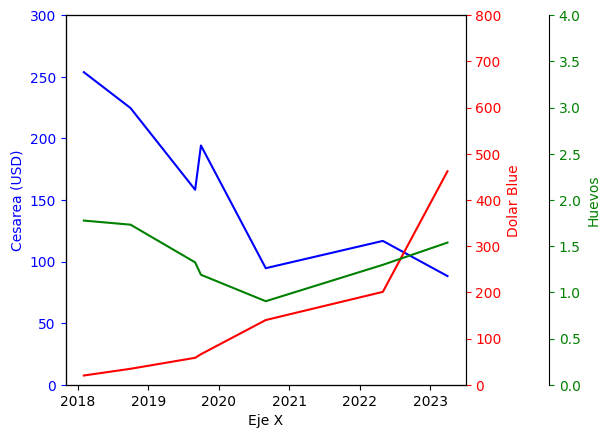

In [133]:
import matplotlib.pyplot as plt

x = df_completo_6.index
y1 = df_completo_6['Valor_cesarea_USD']
y2 = df_completo_6['Valor_dolar_blue']
y3 = df_completo_6['Valor_huevos_USD']

# Crear la figura y los ejes
fig, ax1 = plt.subplots()

# Graficar los datos en el eje izquierdo
ax1.plot(x, y1, 'b-')
ax1.set_ylim(0, 300)
ax1.set_xlabel('Eje X')
ax1.set_ylabel('Cesarea (USD)', color='b')
ax1.tick_params('y', colors='b')

# Crear el primer eje y para el primer eje derecho
ax2 = ax1.twinx()

# Graficar los datos en el primer eje derecho
ax2.plot(x, y2, 'r-')
ax2.set_ylim(0, 800)
ax2.set_ylabel('Dolar Blue', color='r')
ax2.tick_params('y', colors='r')

# Crear el segundo eje y para el segundo eje derecho
ax3 = ax1.twinx()

# Mover el segundo eje y hacia la derecha
ax3.spines['right'].set_position(('outward', 60))

# Graficar los datos en el segundo eje derecho
ax3.plot(x, y3, 'g-')
ax3.set_ylim(0, 4)
ax3.set_ylabel('Huevos', color='g')
ax3.tick_params('y', colors='g')

# Ajustar las etiquetas de los ejes
plt.subplots_adjust(right=0.75)

# Mostrar el gráfico
plt.show()



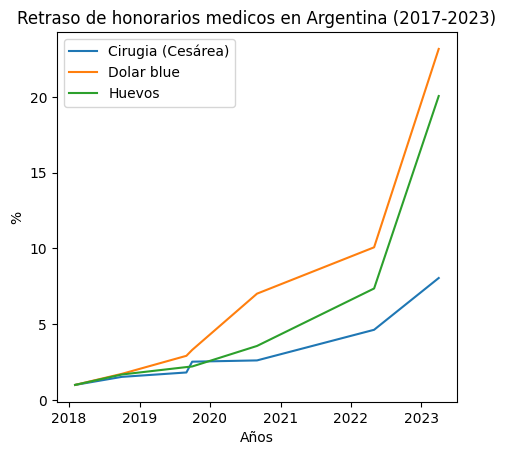

In [134]:
x = df_completo_6.index
y1 = df_completo_6['Incremento cesarea %']
y2 = df_completo_6['Incremento dolar blue %']
y3 = df_completo_6['Incremento huevos %']

# Graficar los datos en el eje izquierdo
plt.plot(x, y1, label='Cirugia (Cesárea)')

# Graficar los datos en el primer eje derecho
plt.plot(x, y2, label = 'Dolar blue')

# Graficar los datos en el segundo eje derecho
plt.plot(x, y3, label = 'Huevos')

# Ajustar las etiquetas de los ejes
plt.subplots_adjust(right=0.75)

plt.xlabel('Años')
plt.ylabel('%')
plt.title('Retraso de honorarios medicos en Argentina (2017-2023)')

# Mostrar una leyenda con los nombres de las variables
plt.legend()

# Mostrar el gráfico
plt.show()

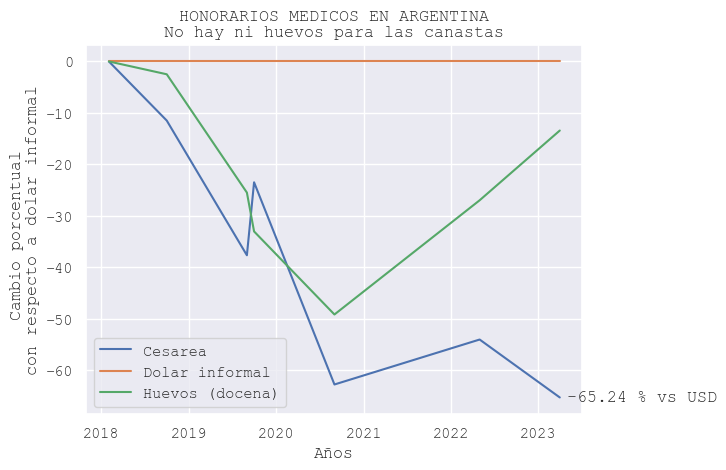

In [135]:
x = df_completo_6.index
y1 = df_completo_6['Disminucion valor cesarea %']
y2 = df_completo_6['Valor nominal dolar blue']
y3 = df_completo_6['Disminucion valor huevos %']

# Configurar el estilo de Seaborn
sns.set(style='darkgrid')
plt.rcParams['font.family'] = 'Courier New'


# Crear el gráfico de líneas con Seaborn
sns.lineplot(x=x, y=y1, label='Cesarea')
sns.lineplot(x=x, y=y2, label='Dolar informal')
sns.lineplot(x=x, y=y3, label='Huevos (docena)')

# Mostrar una leyenda con los nombres de las variables
plt.xlabel('Años')
plt.ylabel('''Cambio porcentual 
con respecto a dolar informal''')
plt.title('''HONORARIOS MEDICOS EN ARGENTINA
No hay ni huevos para las canastas''')

plt.annotate(f'{y1[-1]:.2f} % vs USD', xy=(x[-1], y1[-1]), xytext=(5, 0),
             textcoords='offset points', ha='left', va='center')

# Mostrar el gráfico
plt.show()